# Import the Necessary Packages

In [ ]:
import cProfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import os
import math
import json
import scipy
import time
import sys
import multiprocessing as mp

# this inserts the continuous file into the path
sys.path.insert(0, '/Users/tinkertanker/Documents/Entropica/annealing/master/quantum-inspired-optimisation/')

#from Anneal_cont import Annealer
%matplotlib inline

pd.options.display.float_format = '{:,.1f}'.format
import operator
from operator import itemgetter

from cost_function import *
import solver as slv
import solver_utils as su
import optimiser as opt
import visualisation

In [ ]:
func, mesh = levy()
i1, i2 = mesh[0], mesh[1]

def f():
    '''
    input: tour (list)

    Function that evaluates the cost of a given x1, x2 (euclidean distance)

    output: single cost
    '''
        
    exploration_space = [(i,j) for i in i1 for j in i2]
        # storing this huge dictionary in memory may not be a great idea..
    super_energies = {(i,j):[func(*[i,j]),0] for i,j in exploration_space}
    return super_energies

super_energies = f()

In [ ]:
# this function is not inside the package yet and outside, but the code can be optimized to take advantage of the structure
# anyway
myCostFn = CostFunction(func, mesh, "x1, x2")

print(myCostFn.dimensionality)
print(myCostFn.function)
print(myCostFn.vars_names)

In [ ]:
def move_func(config):
    return config + 0.5*(-1)**(np.random.randint(2))

# Set up the Markov Chain Monte Carlo rule
mcmcRule = su.mcmc_rule(move_func,myCostFn)

# Define the cooling schedule - here a simple geometric one, with constant 0.99
# We choose the initial temperature to be 10 times the maximum value of the cost function
init_beta = 1/(10*max(cost_val))
cooling = su.cooling_schedule(['geometric',0.99,1000], init_beta = init_beta)

pa = population_annealing(myCostFn,mcmcRule,cooling,walkers=101error_thres=10e-2,choice='multinomial')

In [ ]:
maxiters=500
sa_optimiser = opt.optimiser(sa,maxiters)

In [ ]:
class population_annealing:
    def __init__(self, cost_func,
                 mcmc_rule,
                 cooling_schedule):
        
        self._evaluate = cost_func.evaluate_cost
        self._move_func = mcmc_rule._move_func
        self._metropolis_update = mcmc_rule._metropolis_update
        self.method = 'Simulated Annealing'
        self.cooling_schedule = cooling_schedule  
        
        dynamic = hasattr(cooling_schedule, '_dynamic_func')
        if dynamic:
            self._do_iteration = self._dynamic_iteration
        else:
            self._do_iteration = self._basic_iteration
        
        
    def _basic_iteration(self, current_config, beta): 
        
        """
        Simple, static MCMC update rule (only the accept/reject criteria depends on the state of the system)
        """
        
        proposed_config = self._move_func(current_config)
        accept = self._metropolis_update(current_config,proposed_config,beta)
            
        if accept:
            current_config = proposed_config
            
        return current_config, self._evaluate(current_config)
    
    def _dynamic_iteration(self, current_config, beta, extra_dict): 
        
        """
        Dynamic MCMC update that depends on the current state of the system, and requries extra input information,
        and must return extra information (compared to the static case above)
        
        This works by taking in optional additional function arguments, which are executed at specific times to produce the desired result. 
        Two types of functions like this may be:
            
            (1) 'moves': A function that allows the generated moves to be dependent on current conditions, 
                executed at the beginning of each step ----->> NOT SUPPORTED YET
            (2) 'decisions': A function that is executed after the acceptance/rejectance outcome of each step,
                before moving on to the next step. Should be of the form (accept_func, reject_func), specifying what
                is to be done in each case. ---->> DESCRIPTION NEEDS UPDATING
        
        Examples:
            
            - Using (2) allows the temperature updates to be dependent on the current conditions (e.g. in Lam's method) 
        
        Note that these additional functions cannot themselves be dynamic!
        
        """
        
        proposed_config = self._move_func(current_config)
        accept = self._metropolis_update(current_config,proposed_config,beta)
            
        if accept:
            current_config = proposed_config
         
        # Execute the dynamic function
        extra_vals = [i for i in extra_dict.values()]
        beta, dyn_out_vars = self.cooling_schedule._dynamic_func(beta, accept, *extra_vals)

        return current_config, self._evaluate(current_config), beta, dyn_out_vars

In [ ]:
# testing the non assigned taus
class RandomAnneal:

    '''
    Pass the max steps you want to take to the annealer function
    '''

    def __init__(
          self,
        cost_func,
        mcmc_rule,
        cooling_schedule,
        walkers=10,
        error_thres=10e-2, 
        choice='multinomial'
          ):
        '''
        inputs: total number of steps to try, geometric multiplier for annealing schedule
        Initialize parameters
        output: none
        '''
        self._evaluate = cost_func.evaluate_cost
        self._move_func = mcmc_rule._move_func
        self._metropolis_update = mcmc_rule._metropolis_update
        self.method = 'Population Annealing'
        self.cooling_schedule = cooling_schedule  
        
        dynamic = hasattr(cooling_schedule, '_dynamic_func')
        if dynamic:
            self._do_iteration = self._dynamic_iteration
        else:
            self._do_iteration = self._basic_iteration
        
        self.func, self.mesh = func, mesh
        
        self.Tmax, self.exploration_space = maxsteps, explore

        self.i1, self.i2 = self.mesh[0], self.mesh[1]
        self.all_energies = super_energies.copy()
        self.correct_answer, self.error_threshold, self.cumulative_correct = super_energies[min(self.all_energies.keys(), key=(lambda k: self.all_energies[k]))][0], error_thres, 0.0
        
        self.choice = choice
        
        self.walkers_t1, self.walkers_t2, self.initial = walkers, walkers, walkers
        
        self.stat_weight_ratio = dict()
        self.partition_function = 0
        
        self.energy_landscape = dict()
        
        # e_diff is a lambda function used to calculate the ratio of statistical weight
        self.e_diff = lambda x, y: np.exp(-(x[1] - x[0]) * y) 
        
        self.get_min = lambda some_dict: min(some_dict.keys(), key=(lambda n: some_dict[n])) 
        self.get_max = lambda some_dict: max(some_dict.keys(), key=(lambda n: some_dict[n])) 
    

    def _basic_iteration(self, current_config, beta): 
        
        """
        Simple, static MCMC update rule (only the accept/reject criteria depends on the state of the system)
        """
        
        proposed_config = self._move_func(current_config)
        accept = self._metropolis_update(current_config,proposed_config,beta)
            
        if accept:
            current_config = proposed_config
            
        return current_config, self._evaluate(current_config)
    
    def _dynamic_iteration(self, current_config, beta, extra_dict): 
        
        """
        Dynamic MCMC update that depends on the current state of the system, and requries extra input information,
        and must return extra information (compared to the static case above)
        
        This works by taking in optional additional function arguments, which are executed at specific times to produce the desired result. 
        Two types of functions like this may be:
            
            (1) 'moves': A function that allows the generated moves to be dependent on current conditions, 
                executed at the beginning of each step ----->> NOT SUPPORTED YET
            (2) 'decisions': A function that is executed after the acceptance/rejectance outcome of each step,
                before moving on to the next step. Should be of the form (accept_func, reject_func), specifying what
                is to be done in each case. ---->> DESCRIPTION NEEDS UPDATING
        
        Examples:
            
            - Using (2) allows the temperature updates to be dependent on the current conditions (e.g. in Lam's method) 
        
        Note that these additional functions cannot themselves be dynamic!
        
        """
        
        proposed_config = self._move_func(current_config)
        accept = self._metropolis_update(current_config,proposed_config,beta)
            
        if accept:
            current_config = proposed_config
         
        # Execute the dynamic function
        extra_vals = [i for i in extra_dict.values()]
        beta, dyn_out_vars = self.cooling_schedule._dynamic_func(beta, accept, *extra_vals)

        return current_config, self._evaluate(current_config), beta, dyn_out_vars
    
    
    def resample_population(self, walker_pos, mean_val, stat_weight_ratio, Q, tau, choice='multinomial'):
        '''
        input: a walker point
        randomly resample the population N times for each replica, where N is a poisson random variable
        output: either a list of samples or None.
        '''

        rv = dict()
        
        if choice == "poisson":
            # current number of replicas over the previous number of replicas
            tau = {k:(self.initial / mean_val * v) for k,v in tau.items()}
            # generate a list of poisson values based on the array
            rv = {k:np.random.poisson(v) for k,v in tau.items()}
            nums = [v for k,v in rv.items()]
            
        else:
            taus = np.array(list(tau.values()))
            normalized_taus = taus / np.sum(taus)
            nums = np.random.multinomial(self.initial, normalized_taus)
            rv = {k:nums[k] for k in range(len(walker_pos))} # this is not self.initial, this is something else. 
        return rv, nums

    def partition_calc(self, walker_pos, t0, t1, mean_val):
        '''
        input: None
        calculate the statistical weight of a single walker, and also 
        output: parition function and statisticla weight ratios for each walker
        '''
        stat_weight_ratio = dict()
        walk_energies = list()
        
        # 1 iteration
        for k,v in walker_pos.items():
            energy = walker_pos[k][1]
            #self.walker_pos[k][1] = energy # append the cost function the walker's position
            swr = self.e_diff([t0, t1], energy) 
            # potential problem here in when we need to reinstantiate
            if k not in stat_weight_ratio.keys():
                stat_weight_ratio[k] = 0.0
            stat_weight_ratio[k] = swr
            
            walk_energies.append(swr)
            
        partition_function = np.sum([np.exp(-(t1) * i[1]) for i in list(walker_pos.values())])
        Q = np.sum(walk_energies) / mean_val
        tau = {k:stat_weight_ratio[k]/Q for k,v in walker_pos.items()}

        return stat_weight_ratio, partition_function, Q, tau   

    def random_neighbour(self):
        """ 
        input: x (a 2D array)
        
        draw from the entire array space of x1 and x2
        
        output: (newx, newy)
        """

        new_x = np.random.choice(self.i1)
        new_y = np.random.choice(self.i2)

        return [new_x, new_y]
    

    def acceptance_probability(
        self,
        cost,
        new_cost,
        temperature,
        ):
        '''
        inputs: old cost, new cost, current temperature

        calculate probability of acceptance and return it using the metropolis algorithm

        output: probability (0 to 1)
        '''

        return np.exp(-(new_cost - cost) / temperature)
    
    def check_correct(self, energy):
        self.cumulative_correct += np.sum([1 if (i-self.correct_answer)<=self.error_threshold or i<self.correct_answer else 0 for i in energy])
    
    def max_key(self, walker_pos):
        '''
        inputs: none
        finds the minimum value in the dictionary of walkers
        outputs: key of the lowest (best) cost value in the entire dictionary of walkers
        '''
        return min(walker_pos.keys(), key=(lambda k: walker_pos[k][1]))

    def calculate_covariance(self, resampled_B, resampled_B_prime):
        '''
        inputs: resampled_B, resampled_B_prime both containing the position and number of walkers at that position for a B and B prime
        produces a numpy covariance matrix containing the inter and intra covariance between the number of walkers resampled
        output: covariance matrix of (self.walkers_t1 x self.walkers_t1) dimension
        '''
        #distance = lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1]
        #              - y[1]) ** 2)
        
        # can be generalized to take in the parameters for the poisson distribution but better not to compute the cov for that at this time 
        
        # do something here
        
        # calculate all the euclidean distances from the max keys
        
        
                
        euclid_distances = list(resampled_B.keys()) + list(resampled_walkers.keys())
        print(euclid_distances)
        #for k,v in resampled_B_prime.items():

        return euclid_distances
    
    def get_all_affinity(self, swr_affinity, resample_walker):
        #     affinity_keys = {i:[[k for m in v if m[0] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0] for i,j in resample_walker.items()}
        affinity_vals = {i:{k:[m for m in v if m[1] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0 and k not in list(resample_walker.keys())} for i,j in resample_walker.items()}
        return affinity_vals
    
    
    def respawn_walker(self, walker_pos, resampled_walker, tau):
        calculate_swr = lambda x,y: x/y

        # gets those with positive number of resampled walkers
        resample_walker = {k:1 for k,v in resampled_walker.items() if v > 0}

        # takes the walkers with positive resamplings back into the walker_pos
        new_walker_pos = {k:walker_pos[k][:] for k,v in resample_walker.items()}

        # this is the slow part!!
        new_walker_pos = self.assign_walkers(tau, new_walker_pos, walker_pos)

        return new_walker_pos
    
    def get_max_tau(self, taus : dict, new_walker_pos : dict, walker_pos : dict):
        # takes in a dictionary and returns the key of walker which has not been assigned with the maximum tau
        assigned_keys = list(new_walker_pos.keys())
        filtered_tau = {k:v for k,v in taus.items() if k not in assigned_keys}

        max_tau = self.get_min(filtered_tau)
        # max_tau represents the walker we choose

        # generates a random number for each of the 

        accepted = 0 

        while accepted == 0:
            # it's somehow stuck here
            
            # here we iterate through the dictionary and do a monte carlo style check if the current walker is better than the walkers to be chosen 
            # if in some case that everything is rejected, we will run a while loop and try again.
            generate_rn = sorted([(i,np.random.uniform(0, 1)) for i,j in new_walker_pos.items()], reverse=True)

            for i,j in enumerate(generate_rn):
                if random.uniform(0,1) > j[1]:
                    accepted = j[0]
        return max_tau, accepted

    def unassigned(self, walker_pos, new_walker_pos):
        return {k:v for k,v in walker_pos.items() if k not in list(new_walker_pos.keys())}

    def assign_walkers(self, taus, new_walker_pos, walker_pos):
        
        not_assigned = self.unassigned(walker_pos, new_walker_pos)
        if len(not_assigned) > 0:
            max_tau, accepted = self.get_max_tau(taus, new_walker_pos, walker_pos)
            new_walker_pos[max_tau] = walker_pos[accepted][:]
            return self.assign_walkers(taus, new_walker_pos, walker_pos)

        return new_walker_pos
    
    def anneal(self):
        '''
        inputs: none

        function performs annealing and calls random start to kickstart the annealing process. iteratively
        calculates the new cost.

        output: final cost, final state (list of x1 and x2), all costs (list of costs at every timestep)

        '''
        T_list = [1]
        # metrics we want to keep track of
        populations = list()
        free_energy = dict()
        average_cost = list()
        best = list()
        walker_z = list()
        walker_pos, new_walker_pos = dict(), dict()
        
        # keeps track of the number of resamples assigned to each walker
        resample_time = [[1 for _ in range(self.initial)]]
                
        # keeps track of where walkers go ove rtime
        config_time = list()
        
        #taus_over_time = {i:0 for i in range(self.walkers_t1)}
        # generate a state of random walkers with their costs, need to change such that we are generating tours instead of other stuff.

        # generate a state of random walkers with their costs 
        walker_pos = {i:[[np.random.choice(self.i1),
                             np.random.choice(self.i2)]] for i in range(self.walkers_t1)}        
                
        confgs_time = [[v[0] for k,v in walker_pos.items()]]
        
        # append the cost of each state 
        for k,v in walker_pos.items():
            walker_pos[k].append(self.all_energies[tuple(v[0])][0])
            
            # increase the number of walkers at all_energies
            self.all_energies[tuple(v[0])][1] += 1
        
        # gets the maximum value of the key 
        max_key = self.max_key(walker_pos)
        best_cost = [[1, walker_pos[max_key][0], walker_pos[max_key][1]]]

        for temp_step in range(2, self.Tmax+2):
            # calculate the temperature from temp step 2 onward

            fraction = 1/temp_step

            if temp_step > 2:
                if self.lams == 0:
                    T = self.multiplier * fraction if self.multiplier < 1 else fraction
            else:
                T = fraction 

            T_list.append(int(np.round(1/T)))
            
            populations.append(self.walkers_t1)
            
            params = (T_list[-2], T_list[-1], np.mean(populations))
            
            
            stat_weight_ratio, partition_function, Q, tau = self.partition_calc(walker_pos, *params)
            
            new_params = [walker_pos] + [params[-1]] + [stat_weight_ratio, Q, tau, self.choice]
            
            resampled_walker, num_resampled = self.resample_population(*new_params)
            new_walker_pos = self.respawn_walker(walker_pos, resampled_walker, tau)
            resample_time.append(num_resampled)
            config_time.append([v for k,v in new_walker_pos.items()])
            
            # explore a new city configuration for each walker (the annealing step)
            for k,v in new_walker_pos.items():
                
                costs = round(new_walker_pos[k][1], 2)
                states = new_walker_pos[k][0]

                if costs not in self.energy_landscape.keys():
                    self.energy_landscape[costs] = 1
                else:
                    self.energy_landscape[costs] = self.energy_landscape[costs] + 1

                for step in range(self.exploration_space):
                    new_state = self.random_neighbour()
                    new_cost = self.func(*new_state)
                    
                if new_cost < costs or self.acceptance_probability(costs,
                      new_cost, T) >= random.uniform(0, 1):
                    states, costs = new_state, new_cost
                
                new_walker_pos[k][0], new_walker_pos[k][1] = states, costs

                # reassign to best cost if greater than the current best cost
                if costs < best_cost[-1][2]:
                    best_cost.append([temp_step, states, costs/self.initial]) # should i be putting the state or the walker? none of them are meaningful anyway... 
            
            
            best.append(best_cost[-1][2])
                    
            all_costs = np.array([walker_pos[k][1] for k,v in walker_pos.items()])
            
            average_cost.append(np.mean(all_costs))
            
            free_energy[temp_step] = math.log(Q) + math.log(self.walkers_t1)
    
            self.check_correct(all_costs/self.initial)
            
            # only after you are done calculating the covariance, then you reassign the previous to the currxent one

            walker_pos = new_walker_pos.copy()
            
            self.walkers_t1 = self.walkers_t2
            self.walkers_t2 = len(walker_pos)
            new_walker_pos = dict()

        return (
                self.energy_landscape,
                average_cost,
                self.cumulative_correct,
                free_energy,
                best_cost,
                best, # best refers to all the best costs at a given temperature
                populations,
                T_list, 
                walker_z,
                resample_time,
                config_time
                )

# Annealing Code

In [ ]:
# calculate the partition function
partition_function = [ for k,v in super_energies.items()]
for i in range(1, 5000+1):
    energies = super_energies.copy()
	Beta = 1/i
	energies = -Beta * np.array(energies)
	partition_function = np.sum(np.exp(energies))
	self.partition[i] = partition_function
	energy.append(energies)


In [59]:
# testing the non assigned taus
class RandomAnneal:

    '''
    Pass the max steps you want to take to the annealer function
    '''

    def __init__(
          self,
        maxsteps=500,
        explore=30,
        walkers=10,
        error_thres=10e-2, 
        multiplier=1, # by default the multipler is 1 
        acceptrate=0.5,
        lams=0, # by default lams is turned off
        choice='multinomial',
      #accs = [500, 1, 1, 0.5, 0, round((Ncity.n)**0.5), 30]
          ):
        '''
        inputs: total number of steps to try, geometric multiplier for annealing schedule
        Initialize parameters
        output: none
        '''
        
        self.func, self.mesh = func, mesh
        
        self.lams, self.acceptrate, self.multiplier = lams, acceptrate, multiplier 
        self.Tmax, self.exploration_space = maxsteps, explore

        self.i1, self.i2 = self.mesh[0], self.mesh[1]
        self.all_energies = super_energies.copy()
        self.correct_answer, self.error_threshold, self.cumulative_correct = super_energies[min(self.all_energies.keys(), key=(lambda k: self.all_energies[k]))][0], error_thres, 0.0
        
        self.choice = choice
        
        self.walkers_t1, self.walkers_t2, self.initial = walkers, walkers, walkers
        
        self.stat_weight_ratio = dict()
        self.partition_function = 0
        
        self.energy_landscape = dict()
        
        # e_diff is a lambda function used to calculate the ratio of statistical weight
        self.e_diff = lambda x, y: np.exp(-(x[1] - x[0]) * y) 
        
        self.get_min = lambda some_dict: min(some_dict.keys(), key=(lambda n: some_dict[n])) 
        self.get_max = lambda some_dict: max(some_dict.keys(), key=(lambda n: some_dict[n])) 
    
    def resample_population(self, walker_pos, mean_val, stat_weight_ratio, Q, tau, choice='multinomial'):
        '''
        input: a walker point
        randomly resample the population N times for each replica, where N is a poisson random variable
        output: either a list of samples or None.
        '''

        rv = dict()
        
        if choice == "poisson":
            # current number of replicas over the previous number of replicas
            tau = {k:(self.initial / mean_val * v) for k,v in tau.items()}
            # generate a list of poisson values based on the array
            rv = {k:np.random.poisson(v) for k,v in tau.items()}
            nums = [v for k,v in rv.items()]
            
        else:
            taus = np.array(list(tau.values()))
            normalized_taus = taus / np.sum(taus)
            nums = np.random.multinomial(self.initial, normalized_taus)
            rv = {k:nums[k] for k in range(len(walker_pos))} # this is not self.initial, this is something else. 
        return rv, nums

    def partition_calc(self, walker_pos, t0, t1, mean_val):
        '''
        input: None
        calculate the statistical weight of a single walker, and also 
        output: parition function and statisticla weight ratios for each walker
        '''
        stat_weight_ratio = dict()
        walk_energies = list()
        
        # 1 iteration
        for k,v in walker_pos.items():
            energy = walker_pos[k][1]
            #self.walker_pos[k][1] = energy # append the cost function the walker's position
            swr = self.e_diff([t0, t1], energy) 
            # potential problem here in when we need to reinstantiate
            if k not in stat_weight_ratio.keys():
                stat_weight_ratio[k] = 0.0
            stat_weight_ratio[k] = swr
            
            walk_energies.append(swr)
            
        partition_function = np.sum([np.exp(-(t1) * i[1]) for i in list(walker_pos.values())])
        Q = np.sum(walk_energies) / mean_val
        tau = {k:stat_weight_ratio[k]/Q for k,v in walker_pos.items()}

        return stat_weight_ratio, partition_function, Q, tau   

    def random_neighbour(self):
        """ 
        input: x (a 2D array)
        
        draw from the entire array space of x1 and x2
        
        output: (newx, newy)
        """

        new_x = np.random.choice(self.i1)
        new_y = np.random.choice(self.i2)

        return [new_x, new_y]
    
    def f(self):
        '''
        input: tour (list)

        Function that evaluates the cost of a given x1, x2 (euclidean distance)

        output: single cost
        '''
        
        exploration_space = [(i,j) for i in self.i1 for j in self.i2]
        # storing this huge dictionary in memory may not be a great idea..
        super_energies = {(i,j):[self.func(*[i,j]),0] for i,j in exploration_space}
        return super_energies

    def acceptance_probability(
        self,
        cost,
        new_cost,
        temperature,
        ):
        '''
        inputs: old cost, new cost, current temperature

        calculate probability of acceptance and return it using the metropolis algorithm

        output: probability (0 to 1)
        '''

        return np.exp(-(new_cost - cost) / temperature)
    
    def check_correct(self, energy):
        self.cumulative_correct += np.sum([1 if (i-self.correct_answer)<=self.error_threshold or i<self.correct_answer else 0 for i in energy])
    
    def max_key(self, walker_pos):
        '''
        inputs: none
        finds the minimum value in the dictionary of walkers
        outputs: key of the lowest (best) cost value in the entire dictionary of walkers
        '''
        return min(walker_pos.keys(), key=(lambda k: walker_pos[k][1]))

    def calculate_covariance(self, resampled_B, resampled_B_prime):
        '''
        inputs: resampled_B, resampled_B_prime both containing the position and number of walkers at that position for a B and B prime
        produces a numpy covariance matrix containing the inter and intra covariance between the number of walkers resampled
        output: covariance matrix of (self.walkers_t1 x self.walkers_t1) dimension
        '''
        #distance = lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1]
        #              - y[1]) ** 2)
        
        # can be generalized to take in the parameters for the poisson distribution but better not to compute the cov for that at this time 
        
        # do something here
        
        # calculate all the euclidean distances from the max keys
        
        
                
        euclid_distances = list(resampled_B.keys()) + list(resampled_walkers.keys())
        print(euclid_distances)
        #for k,v in resampled_B_prime.items():

        return euclid_distances
    
    def get_all_affinity(self, swr_affinity, resample_walker):
        #     affinity_keys = {i:[[k for m in v if m[0] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0] for i,j in resample_walker.items()}
        affinity_vals = {i:{k:[m for m in v if m[1] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0 and k not in list(resample_walker.keys())} for i,j in resample_walker.items()}
        return affinity_vals
    
    
    def respawn_walker(self, walker_pos, resampled_walker, tau):
        calculate_swr = lambda x,y: x/y

        # gets those with positive number of resampled walkers
        resample_walker = {k:1 for k,v in resampled_walker.items() if v > 0}

        # takes the walkers with positive resamplings back into the walker_pos
        new_walker_pos = {k:walker_pos[k][:] for k,v in resample_walker.items()}

        # this is the slow part!!
        new_walker_pos = self.assign_walkers(tau, new_walker_pos, walker_pos)

        return new_walker_pos
    
    def get_max_tau(self, taus : dict, new_walker_pos : dict, walker_pos : dict):
        # takes in a dictionary and returns the key of walker which has not been assigned with the maximum tau
        assigned_keys = list(new_walker_pos.keys())
        filtered_tau = {k:v for k,v in taus.items() if k not in assigned_keys}

        max_tau = self.get_min(filtered_tau)
        # max_tau represents the walker we choose

        # generates a random number for each of the 

        accepted = 0 

        while accepted == 0:
            # it's somehow stuck here
            
            # here we iterate through the dictionary and do a monte carlo style check if the current walker is better than the walkers to be chosen 
            # if in some case that everything is rejected, we will run a while loop and try again.
            generate_rn = sorted([(i,np.random.uniform(0, 1)) for i,j in new_walker_pos.items()], reverse=True)

            for i,j in enumerate(generate_rn):
                if random.uniform(0,1) > j[1]:
                    accepted = j[0]
        return max_tau, accepted

    def unassigned(self, walker_pos, new_walker_pos):
        return {k:v for k,v in walker_pos.items() if k not in list(new_walker_pos.keys())}

    def assign_walkers(self, taus, new_walker_pos, walker_pos):
        
        not_assigned = self.unassigned(walker_pos, new_walker_pos)
        if len(not_assigned) > 0:
            max_tau, accepted = self.get_max_tau(taus, new_walker_pos, walker_pos)
            new_walker_pos[max_tau] = walker_pos[accepted][:]
            return self.assign_walkers(taus, new_walker_pos, walker_pos)

        return new_walker_pos
    
    def anneal(self):
        '''
        inputs: none

        function performs annealing and calls random start to kickstart the annealing process. iteratively
        calculates the new cost.

        output: final cost, final state (list of x1 and x2), all costs (list of costs at every timestep)

        '''
        T_list = [1]
        # metrics we want to keep track of
        populations = list()
        free_energy = dict()
        average_cost = list()
        best = list()
        walker_z = list()
        walker_pos, new_walker_pos = dict(), dict()
        
        # keeps track of the number of resamples assigned to each walker
        resample_time = [[1 for _ in range(self.initial)]]
                
        # keeps track of where walkers go ove rtime
        config_time = list()
        
        #taus_over_time = {i:0 for i in range(self.walkers_t1)}
        # generate a state of random walkers with their costs, need to change such that we are generating tours instead of other stuff.

        # generate a state of random walkers with their costs 
        walker_pos = {i:[[np.random.choice(self.i1),
                             np.random.choice(self.i2)]] for i in range(self.walkers_t1)}        
                
        confgs_time = [[v[0] for k,v in walker_pos.items()]]
        
        # append the cost of each state 
        for k,v in walker_pos.items():
            walker_pos[k].append(self.all_energies[tuple(v[0])][0])
            
            # increase the number of walkers at all_energies
            self.all_energies[tuple(v[0])][1] += 1
        
        # gets the maximum value of the key 
        max_key = self.max_key(walker_pos)
        best_cost = [[1, walker_pos[max_key][0], walker_pos[max_key][1]]]

        for temp_step in range(2, self.Tmax+2):
            # calculate the temperature from temp step 2 onward

            fraction = 1/temp_step

            if temp_step > 2:
                if self.lams == 0:
                    T = self.multiplier * fraction if self.multiplier < 1 else fraction
            else:
                T = fraction 

            T_list.append(int(np.round(1/T)))
            
            populations.append(self.walkers_t1)
            
            params = (T_list[-2], T_list[-1], np.mean(populations))
            
            
            stat_weight_ratio, partition_function, Q, tau = self.partition_calc(walker_pos, *params)
            
            new_params = [walker_pos] + [params[-1]] + [stat_weight_ratio, Q, tau, self.choice]
            
#             print("why")
            resampled_walker, num_resampled = self.resample_population(*new_params)
#             print("sigh")
            new_walker_pos = self.respawn_walker(walker_pos, resampled_walker, tau)
#             print("hi")
            resample_time.append(num_resampled)
            config_time.append([v for k,v in new_walker_pos.items()])
            
            # explore a new city configuration for each walker (the annealing step)
            for k,v in new_walker_pos.items():
                
                costs = round(new_walker_pos[k][1], 2)
                states = new_walker_pos[k][0]

                if costs not in self.energy_landscape.keys():
                    self.energy_landscape[costs] = 1
                else:
                    self.energy_landscape[costs] = self.energy_landscape[costs] + 1

#                 walker_pos_check = walker_pos.copy()
                for step in range(self.exploration_space):
                    new_state = self.random_neighbour()
                    new_cost = self.func(*new_state)
                    
#                     walker_pos_check[k][1] = new_cost
#                     new_stat_weight_ratio, new_partition_function, new_Q, new_tau = self.partition_calc(walker_pos_check, *params)
#                     walker_z.append([temp_step, step, k, new_partition_function])
                    
                if new_cost < costs or self.acceptance_probability(costs,
                      new_cost, T) >= random.uniform(0, 1):
                    states, costs = new_state, new_cost
                
                    if self.lams == 1:
                        self.acceprate = 1 / 500 * (499 * self.acceptrate + 1)
                else:
                    
                    if self.lams == 1:

                        self.acceptrate = 1 / 500 * (499 * self.acceptrate)

                        # check conditions

                        if fraction < 0.15:
                            LamRate = 0.44 + 0.56 * 560 ** (-temp_step
                              / (self.Tmax * 0.15))
                        elif fraction < 0.65:
                            LamRate = 0.44
                        else:
                            LamRate = 0.44 * 440 ** ((-fraction - 0.65) / 0.35)

                        if LamRate < self.acceptrate:
                            T *= 0.99
                        else:
                            T *= 1 / 0.999
                
                new_walker_pos[k][0], new_walker_pos[k][1] = states, costs

                # reassign to best cost if greater than the current best cost
                if costs < best_cost[-1][2]:
                    best_cost.append([temp_step, states, costs/self.initial]) # should i be putting the state or the walker? none of them are meaningful anyway... 
            
#             print("died")
            
            # this is where we can calculate the covariance matrix between two different temperatuers for different positions
            #resampled_B_prime = {tuple(walker_pos[k][0]):v for k,v in resampled_walker.items()}
            #covariance = self.calculate_covariance(resampled_B, resampled_B_prime)
            
            best.append(best_cost[-1][2])
                    
            all_costs = np.array([walker_pos[k][1] for k,v in walker_pos.items()])
            
            average_cost.append(np.mean(all_costs))
            
            free_energy[temp_step] = math.log(Q) + math.log(self.walkers_t1)
    
            self.check_correct(all_costs/self.initial)
            
            # only after you are done calculating the covariance, then you reassign the previous to the currxent one

            walker_pos = new_walker_pos.copy()
            
            self.walkers_t1 = self.walkers_t2
            self.walkers_t2 = len(walker_pos)
            new_walker_pos = dict()

        return (
                self.energy_landscape,
                average_cost,
                self.cumulative_correct,
                free_energy,
                best_cost,
                best, # best refers to all the best costs at a given temperature
                populations,
                T_list, 
                walker_z,
                resample_time,
                config_time
                )

In [21]:
class TauAnneal:

    '''
    Pass the max steps you want to take to the annealer function
    '''

    def __init__(
          self,
        maxsteps=500,
        explore=30,
        walkers=10,
        error_thres=10e-2, 
        multiplier=1, # by default the multipler is 1 
        acceptrate=0.5,
        lams=0, # by default lams is turned off
        choice='multinomial',
      #accs = [500, 1, 1, 0.5, 0, round((Ncity.n)**0.5), 30]
          ):
        '''
        inputs: total number of steps to try, geometric multiplier for annealing schedule
        Initialize parameters
        output: none
        '''
        self.func, self.mesh = func, mesh
        
        self.lams, self.acceptrate, self.multiplier = lams, acceptrate, multiplier 
        self.Tmax, self.exploration_space = maxsteps, explore

        self.i1, self.i2 = self.mesh[0], self.mesh[1]
        self.all_energies = super_energies.copy()
        self.correct_answer, self.error_threshold, self.cumulative_correct = super_energies[min(self.all_energies.keys(), key=(lambda k: self.all_energies[k]))][0], error_thres, 0.0
        
        self.choice = choice
        
        self.walkers_t1, self.walkers_t2, self.initial = walkers, walkers, walkers
        
        self.stat_weight_ratio = dict()
        self.partition_function = 0
        
        self.energy_landscape = dict()
        
        # e_diff is a lambda function used to calculate the ratio of statistical weight
        self.e_diff = lambda x, y: np.exp(-(x[1] - x[0]) * y) 
    
    def resample_population(self, walker_pos, mean_val, stat_weight_ratio, Q, tau, choice='multinomial'):
        '''
        input: a walker point
        randomly resample the population N times for each replica, where N is a poisson random variable
        output: either a list of samples or None.
        '''

        rv = dict()
        
        if choice == "poisson":
            # current number of replicas over the previous number of replicas
            tau = {k:(self.initial / mean_val * v) for k,v in tau.items()}
            # generate a list of poisson values based on the array
            rv = {k:np.random.poisson(v) for k,v in tau.items()}
            nums = [v for k,v in rv.items()]
            
        else:
            taus = np.array(list(tau.values()))
            normalized_taus = taus / np.sum(taus)
            nums = np.random.multinomial(self.initial, normalized_taus)
            rv = {k:nums[k] for k in range(len(walker_pos))} # this is not self.initial, this is something else. 
        return rv, nums

    def partition_calc(self, walker_pos, t0, t1, mean_val):
        '''
        input: None
        calculate the statistical weight of a single walker, and also 
        output: parition function and statisticla weight ratios for each walker
        '''
        stat_weight_ratio = dict()
        walk_energies = list()
        
        # 1 iteration
        for k,v in walker_pos.items():
            energy = walker_pos[k][1]
            #self.walker_pos[k][1] = energy # append the cost function the walker's position
            swr = self.e_diff([t0, t1], energy) 
            # potential problem here in when we need to reinstantiate
            if k not in stat_weight_ratio.keys():
                stat_weight_ratio[k] = 0.0
            stat_weight_ratio[k] = swr
            
            walk_energies.append(swr)
            
        partition_function = np.sum([np.exp(-(t1) * i[1]) for i in list(walker_pos.values())])
        Q = np.sum(walk_energies) / mean_val
        tau = {k:stat_weight_ratio[k]/Q for k,v in walker_pos.items()}

        return stat_weight_ratio, partition_function, Q, tau   

    def random_neighbour(self):
        """ 
        input: x (a 2D array)
        
        draw from the entire array space of x1 and x2
        
        output: (newx, newy)
        """

        new_x = np.random.choice(self.i1)
        new_y = np.random.choice(self.i2)

        return [new_x, new_y]
    
    def f(self):
        '''
        input: tour (list)

        Function that evaluates the cost of a given x1, x2 (euclidean distance)

        output: single cost
        '''
        
        exploration_space = [(i,j) for i in self.i1 for j in self.i2]
        # storing this huge dictionary in memory may not be a great idea..
        super_energies = {(i,j):[self.func(*[i,j]),0] for i,j in exploration_space}
        return super_energies

    def acceptance_probability(
        self,
        cost,
        new_cost,
        temperature,
        ):
        '''
        inputs: old cost, new cost, current temperature

        calculate probability of acceptance and return it using the metropolis algorithm

        output: probability (0 to 1)
        '''

        return np.exp(-(new_cost - cost) / temperature)
    
    def check_correct(self, energy):
        self.cumulative_correct += np.sum([1 if (i-self.correct_answer)<=self.error_threshold or i<self.correct_answer else 0 for i in energy])
    
    def max_key(self, walker_pos):
        '''
        inputs: none
        finds the minimum value in the dictionary of walkers
        outputs: key of the lowest (best) cost value in the entire dictionary of walkers
        '''
        return min(walker_pos.keys(), key=(lambda k: walker_pos[k][1]))

    def calculate_covariance(self, resampled_B, resampled_B_prime):
        '''
        inputs: resampled_B, resampled_B_prime both containing the position and number of walkers at that position for a B and B prime
        produces a numpy covariance matrix containing the inter and intra covariance between the number of walkers resampled
        output: covariance matrix of (self.walkers_t1 x self.walkers_t1) dimension
        '''
        #distance = lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1]
        #              - y[1]) ** 2)
        
        # can be generalized to take in the parameters for the poisson distribution but better not to compute the cov for that at this time 
        
        # do something here
        
        # calculate all the euclidean distances from the max keys
        
        
                
        euclid_distances = list(resampled_B.keys()) + list(resampled_walkers.keys())
        print(euclid_distances)
        #for k,v in resampled_B_prime.items():

        return euclid_distances
    
    def get_all_affinity(self, swr_affinity, resample_walker):
        #     affinity_keys = {i:[[k for m in v if m[0] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0] for i,j in resample_walker.items()}
        affinity_vals = {i:{k:[m for m in v if m[1] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0 and k not in list(resample_walker.keys())} for i,j in resample_walker.items()}
        return affinity_vals
    
    
    def respawn_walker(self, walker_pos, resampled_walker, tau):
        calculate_swr = lambda x,y: x/y
        # gets those with positive number of resampled walkers
        resample_walker = {k:1 for k,v in resampled_walker.items() if v > 0}
        # takes the walkers with positive resamplings back into the walker_pos
        new_walker_pos = {k:walker_pos[k][:] for k,v in resample_walker.items()}
        deleted_items = list()
        
        swr_affinity = {k:[(calculate_swr(v,tau[i]), i) for i,j in resample_walker.items() if k != i] for k,v in tau.items()}
        
        resample_affinity_vals = self.get_all_affinity(swr_affinity, resample_walker)
        
        for k,v in resample_affinity_vals.items():
            value = [n for m,n in v.items() if m not in deleted_items]
            
            sorted_dict = sorted(value, reverse=True)[0:(resampled_walker[k] - resample_walker[k])]
            res_items = [m for m,n in v.items() if n in sorted_dict]
            rejects = len(sorted_dict) - resample_walker[k]
            rejected = sorted_dict[rejects:]

            for i in res_items:

                new_walker_pos[i] = walker_pos[k][:]
                resample_walker[k] += 1
                deleted_items.append(i)

        return new_walker_pos
    
    def anneal(self):
        '''
        inputs: none

        function performs annealing and calls random start to kickstart the annealing process. iteratively
        calculates the new cost.

        output: final cost, final state (list of x1 and x2), all costs (list of costs at every timestep)

        '''
        T_list = [1]
        # metrics we want to keep track of
        populations = list()
        free_energy = dict()
        average_cost = list()
        best = list()
        walker_z = list()
        walker_pos, new_walker_pos = dict(), dict()
        
        # keeps track of the number of resamples assigned to each walker
        resample_time = [[1 for _ in range(self.initial)]]
                
        # keeps track of where walkers go ove rtime
        config_time = list()
        
        #taus_over_time = {i:0 for i in range(self.walkers_t1)}
        # generate a state of random walkers with their costs, need to change such that we are generating tours instead of other stuff.

        # generate a state of random walkers with their costs 
        walker_pos = {i:[[np.random.choice(self.i1),
                             np.random.choice(self.i2)]] for i in range(self.walkers_t1)}        
                
        confgs_time = [[v[0] for k,v in walker_pos.items()]]
        
        # append the cost of each state 
        for k,v in walker_pos.items():
            walker_pos[k].append(self.all_energies[tuple(v[0])][0])
            
            # increase the number of walkers at all_energies
            self.all_energies[tuple(v[0])][1] += 1
        
        # gets the maximum value of the key 
        max_key = self.max_key(walker_pos)
        best_cost = [[1, walker_pos[max_key][0], walker_pos[max_key][1]]]

        for temp_step in range(2, self.Tmax+2):
            # calculate the temperature from temp step 2 onward

            fraction = 1/temp_step

            if temp_step > 2:
                if self.lams == 0:
                    T = self.multiplier * fraction if self.multiplier < 1 else fraction
            else:
                T = fraction 

            T_list.append(int(np.round(1/T)))
            
            populations.append(self.walkers_t1)
            
            params = (T_list[-2], T_list[-1], np.mean(populations))

            stat_weight_ratio, partition_function, Q, tau = self.partition_calc(walker_pos, *params)
            new_params = [walker_pos] + [params[-1]] + [stat_weight_ratio, Q, tau, self.choice]
            resampled_walker, num_resampled = self.resample_population(*new_params)
            
            new_walker_pos = self.respawn_walker(walker_pos, resampled_walker, tau)
            
            resample_time.append(num_resampled)
            config_time.append([v for k,v in new_walker_pos.items()])
            
            # explore a new city configuration for each walker (the annealing step)
            for k,v in new_walker_pos.items():
                
                costs = round(new_walker_pos[k][1], 2)
                states = new_walker_pos[k][0]

                if costs not in self.energy_landscape.keys():
                    self.energy_landscape[costs] = 1
                else:
                    self.energy_landscape[costs] = self.energy_landscape[costs] + 1

#                 walker_pos_check = walker_pos.copy()
                for step in range(self.exploration_space):
                    new_state = self.random_neighbour()
                    new_cost = self.func(*new_state)
                    
#                     walker_pos_check[k][1] = new_cost
#                     new_stat_weight_ratio, new_partition_function, new_Q, new_tau = self.partition_calc(walker_pos_check, *params)
#                     walker_z.append([temp_step, step, k, new_partition_function])
                    
                if new_cost < costs or self.acceptance_probability(costs,
                      new_cost, T) >= random.uniform(0, 1):
                    states, costs = new_state, new_cost
                
                    if self.lams == 1:
                        self.acceprate = 1 / 500 * (499 * self.acceptrate + 1)
                else:
                    
                    if self.lams == 1:

                        self.acceptrate = 1 / 500 * (499 * self.acceptrate)

                        # check conditions

                        if fraction < 0.15:
                            LamRate = 0.44 + 0.56 * 560 ** (-temp_step
                              / (self.Tmax * 0.15))
                        elif fraction < 0.65:
                            LamRate = 0.44
                        else:
                            LamRate = 0.44 * 440 ** ((-fraction - 0.65) / 0.35)

                        if LamRate < self.acceptrate:
                            T *= 0.99
                        else:
                            T *= 1 / 0.999

                new_walker_pos[k][0], new_walker_pos[k][1] = states, costs

                # reassign to best cost if greater than the current best cost
                if costs < best_cost[-1][2]:
                    best_cost.append([temp_step, states, costs/self.initial]) # should i be putting the state or the walker? none of them are meaningful anyway... 
            
            
            # this is where we can calculate the covariance matrix between two different temperatuers for different positions
            #resampled_B_prime = {tuple(walker_pos[k][0]):v for k,v in resampled_walker.items()}
            #covariance = self.calculate_covariance(resampled_B, resampled_B_prime)
            
            best.append(best_cost[-1][2])
                    
            all_costs = np.array([walker_pos[k][1] for k,v in walker_pos.items()])
            
            average_cost.append(np.mean(all_costs))
            
            free_energy[temp_step] = math.log(Q) + math.log(self.walkers_t1)
    
            self.check_correct(all_costs/self.initial)
            
            # only after you are done calculating the covariance, then you reassign the previous to the currxent one

            walker_pos = new_walker_pos.copy()
            
            self.walkers_t1 = self.walkers_t2
            self.walkers_t2 = len(walker_pos)
            new_walker_pos = dict()

        return (
                self.energy_landscape,
                average_cost,
                self.cumulative_correct,
                free_energy,
                best_cost,
                best, # best refers to all the best costs at a given temperature
                populations,
                T_list, 
                walker_z,
                resample_time,
                config_time
                )

In [ ]:
taus = {0: 4.979481459771921e-19, 1: 8.906010064543437e-104, 2: 2.9010633729504283e-50, 3: 2.909187059354772e-56, 4: 7.945645518559665e-09, 5: 8.660848262223333e-66, 6: 3.5271852989438855e-69, 7: 3.744975658012282e-22, 8: 1.3732738459480639e-65, 9: 2.316272193606615e-19, 10: 1.0649791359042534e-53, 11: 3.495811224642755e-36, 12: 8.122153210145312e-42, 13: 8.396737416695002e-86, 14: 7.080194234845007e-99, 15: 1.9013658268336554e-37, 16: 4.1363855485409126e-51, 17: 6.794105686579909e-83, 18: 2.8852876373243087e-49, 19: 4.4253055046909023e-23, 20: 5.517441600479428e-51, 21: 2.4340543560469156e-27, 22: 2.7696764341527948e-77, 23: 9.376072147534471e-110, 24: 1.513499538709749e-76, 25: 6.435449012887977e-88, 26: 4.1223880823846603e-81, 27: 1.2878218181936917e-46, 28: 5.465955887553644e-50, 29: 3.765333408982003e-79, 30: 6.736207538673744e-08, 31: 2.673402786589717e-12, 32: 5.204636539175555e-19, 33: 7.992444259775237e-46, 34: 1.3521088886371985e-150, 35: 1.5097206308787477e-12, 36: 3.1627657432689353e-65, 37: 4.733640167815339e-08, 38: 5.855853620694806e-22, 39: 7.663579852636736e-69, 40: 8.053214052957187e-92, 41: 2.994698183457118e-37, 42: 4.36152257428427e-08, 43: 2.7924061726193672e-18, 44: 86.21101390558884, 45: 3.003387459898819e-29, 46: 3.869857232885313e-42, 47: 9.084419036572294e-69, 48: 9.698573039984019e-114, 49: 6.295915663894739e-48, 50: 3.39696973093878e-39, 51: 2.0585228416143442e-25, 52: 1.8006256694664823e-103, 53: 3.4316691031387315e-84, 54: 5.3355204366997785e-48, 55: 3.704726716015464e-65, 56: 3.2420644244489503e-41, 57: 1.217892073805362e-84, 58: 4.532257543205371e-51, 59: 1.6170087778778006e-11, 60: 2.2296603899319717e-47, 61: 2.7345506899612595e-109, 62: 4.950018408047005e-20, 63: 4.987717022938297e-79, 64: 1.749705897792825e-10, 65: 1.7826231702865334e-20, 66: 5.557289016266856e-77, 67: 3.557499894258665e-83, 68: 5.899915018195347e-80, 69: 1.2017379381904272e-49, 70: 1.227152203069028e-71, 71: 3.299364156602039e-05, 72: 7.227891434981451e-21, 73: 3.8934721269661133e-26, 74: 1.845361652632113e-24, 75: 8.669908722234362e-14, 76: 4.26233589882733e-109, 77: 0.00010348102976916315, 78: 4.1826746358028446e-61, 79: 5.9812632889018665e-46, 80: 1.9160911989439013e-59, 81: 1.210448675833256e-75, 82: 1.0615992665130984e-25, 83: 7.730073964061945e-09, 84: 3.266748079028032e-57, 85: 1.7421892301642964e-55, 86: 3.687446574739879e-36, 87: 0.05480419949587991, 88: 2.748641311769773e-16, 89: 3.4767167784401154e-08, 90: 2.795957006635664e-77, 91: 9.35893598284094e-56, 92: 1.1746636974837712e-56, 93: 9.108655418895802, 94: 4.633748104190869e-43, 95: 3.542168916575115e-62, 96: 1.857356950810916e-67, 97: 1.1773123316102888e-42, 98: 4.625389792396117, 99: 7.058873800468946e-62}
walker_pos = {0: [[6.756756756756758, -2.992992992992993], 49.822956574294814], 1: [[-8.578578578578579, 9.6996996996997], 244.96128890287554], 2: [[0.7707707707707705, -10.0], 121.7433428680723], 3: [[-7.977977977977978, -4.374374374374375], 135.55605709503757], 4: [[2.9929929929929937, -2.6526526526526526], 26.329807360334858], 5: [[-6.276276276276276, -4.774774774774775], 157.49096903655112], 6: [[7.837837837837839, 9.61961961961962], 165.29703679792675], 7: [[-4.014014014014014, -3.353353353353353], 57.015622497263536], 8: [[6.896896896896898, -6.876876876876877], 157.02999905539443], 9: [[6.236236236236238, 2.1121121121121114], 50.588323255097315], 10: [[-7.4374374374374375, 2.5525525525525516], 129.65322028889454], 11: [[9.6996996996997, 3.9739739739739743], 89.32066345745747], 12: [[-0.39039039039039025, 8.198198198198199], 102.29314418154482], 13: [[9.1991991991992, 7.177177177177178], 203.57364033834034], 14: [[-9.91991991991992, 7.7177177177177185], 233.67778843326045], 15: [[6.756756756756758, -5.075075075075075], 92.23224152511182], 16: [[-8.038038038038039, -1.7317317317317311], 123.69118296058176], 17: [[9.15915915915916, 9.91991991991992], 196.8776728614979], 18: [[-9.53953953953954, 2.3123123123123115], 119.4462105292184], 19: [[2.4124124124124116, 8.058058058058059], 59.15128339065762], 20: [[-8.8988988988989, -1.2912912912912908], 123.40309103649993], 21: [[-3.9739739739739743, -2.8728728728728727], 68.95940475301951], 22: [[-4.634634634634635, -7.177177177177177], 183.95948722641972], 23: [[-5.395395395395395, -9.27927927927928], 258.72536487010314], 24: [[-6.856856856856857, -7.4174174174174174], 182.26120809133104], 25: [[-9.45945945945946, -6.376376376376376], 208.44483213666902], 26: [[-7.717717717717718, 5.8358358358358355], 192.77212547391042], 27: [[-5.595595595595595, 7.337337337337338], 113.3451275680049], 28: [[0.6706706706706704, -10.0], 121.10988120104248], 29: [[6.376376376376378, -8.318318318318319], 188.25755150283538], 30: [[4.114114114114114, 2.8728728728728736], 24.19234922559317], 31: [[4.994994994994995, -0.1701701701701701], 34.326834571514], 32: [[0.5705705705705704, -5.995995995995996], 49.77873246490645], 33: [[9.57957957957958, 5.655655655655655], 111.51958321834422], 34: [[-9.93993993993994, 9.15915915915916], 352.7652640042757], 35: [[5.175175175175175, -3.013013013013013], 34.89826206336113], 36: [[-2.5125125125125125, 9.23923923923924], 156.19574973307684], 37: [[-3.213213213213213, 3.0330330330330337], 24.545151814407298], 38: [[-3.8338338338338342, 4.454454454454455], 56.56859583446784], 39: [[8.63863863863864, 6.1761761761761775], 164.52105776680082], 40: [[-8.438438438438439, 9.31931931931932], 217.43092285094775], 41: [[-7.4574574574574575, 4.334334334334335], 91.77797055623972], 42: [[0.4904904904904903, 5.555555555555555], 24.627025101746536], 43: [[2.5525525525525516, 6.916916916916918], 48.09879359075367], 44: [[-0.2702702702702702, 1.9519519519519513], 3.222367627445266], 45: [[-3.9939939939939944, -2.8528528528528527], 73.3543924603531], 46: [[-7.697697697697698, 4.634634634634635], 103.0345218585954], 47: [[9.8998998998999, 4.2142142142142145], 164.35097623280808], 48: [[-9.61961961961962, 7.497497497497498], 267.9018874043929], 49: [[9.93993993993994, -4.994994994994995], 116.36334891635644], 50: [[4.674674674674675, -8.018018018018019], 96.25710041663571], 51: [[5.315315315315315, 6.0960960960960975], 64.52180423492217], 52: [[-5.7557557557557555, -8.238238238238239], 244.25729594821277], 53: [[-7.157157157157157, -8.93893893893894], 199.8632666181711], 54: [[7.897897897897899, -4.2742742742742745], 116.52886360080129], 55: [[-5.7757757757757755, -6.116116116116116], 156.0375871179243], 56: [[-4.934934934934935, -4.494494494494495], 100.90894408629659], 57: [[7.217217217217218, 9.85985985985986], 200.89919182397276], 58: [[1.2712712712712708, -8.598598598598599], 123.59978514190936], 59: [[2.7127127127127117, 5.135135135135135], 32.52702358233779], 60: [[4.1741741741741745, -8.458458458458459], 115.09881565683536], 61: [[10.0, -6.856856856856857], 257.6549735640019], 62: [[7.457457457457458, -1.3313313313313309], 52.131476132989235], 63: [[-10.0, 1.9119119119119112], 187.9764096203686], 64: [[1.8118118118118112, -3.9339339339339343], 30.14556878301191], 65: [[7.837837837837839, 0.6306306306306304], 53.152781457701266], 66: [[-8.458458458458459, 8.338338338338339], 183.26310732666997], 67: [[-8.618618618618619, 8.398398398398399], 197.5246702657268], 68: [[-7.957957957957958, 8.418418418418419], 190.1110350608908], 69: [[-2.7127127127127126, -6.176176176176176], 120.32206633431693], 70: [[8.67867867867868, -6.536536536536536], 170.95801096813975], 71: [[2.6726726726726717, 4.454454454454455], 17.99836126335988], 72: [[-5.555555555555555, -1.3513513513513509], 54.0555051688006], 73: [[0.41041041041041026, -5.895895895895896], 66.1870766491785], 74: [[-6.796796796796797, 1.0110110110110107], 62.32853252436616], 75: [[-1.9719719719719713, -3.473473473473473], 37.75549860765964], 76: [[-8.358358358358359, -6.756756756756756], 257.21112336177066], 77: [[-1.3313313313313309, -1.551551551551551], 16.855287817791854], 78: [[7.397397397397398, -6.116116116116116], 146.70590533418124], 79: [[-5.7957957957957955, 5.895895895895896], 111.80944804822884], 80: [[5.995995995995996, 8.178178178178179], 142.88139877809846], 81: [[-5.555555555555555, -7.897897897897898], 180.18205644568212], 82: [[8.87887887887888, 0.3503503503503502], 65.18401638022077], 83: [[-0.4504504504504503, 5.535535535535535], 26.357312974429554], 84: [[6.936936936936938, 8.118118118118119], 137.74272085029068], 85: [[6.636636636636638, -5.195195195195195], 133.7662031825131], 86: [[-5.215215215215215, -2.1321321321321323], 89.26729468291018], 87: [[-0.41041041041041026, -1.451451451451451], 10.583154023307221], 88: [[-3.093093093093093, 5.975975975975976], 43.50942033524502], 89: [[4.494494494494495, 1.7917917917917912], 24.853757918449887], 90: [[-6.956956956956957, 6.796796796796798], 183.9500432815073], 91: [[6.636636636636638, -8.97897897897898], 134.38759916916507], 92: [[-9.1991991991992, -3.9739739739739743], 136.46294888442455], 93: [[2.7327327327327318, 1.2312312312312308], 5.469940462074692], 94: [[5.035035035035035, 9.47947947947948], 105.15695850087127], 95: [[6.0560560560560575, -9.97997997997998], 149.17470210628332], 96: [[-8.118118118118119, -3.433433433433433], 161.3332123161127], 97: [[-4.734734734734735, 7.577577577577578], 104.22450531869791], 98: [[-0.1501501501501501, 2.5925925925925917], 6.147604921629306], 99: [[-7.5575575575575575, 2.5125125125125116], 148.48515581367664]}
resampled_walker = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 85, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 1, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 8, 94: 0, 95: 0, 96: 0, 97: 0, 98: 6, 99: 0}

print(walker_pos.keys())
# walker_pos = {1:[[5,3], 2], 2:[[3,4], 1], 3:[[1,1], 6], 4:[[2,4], 7]}

# need to append to time config after you are done with the steps below!
time_config = {k:v for k,v in walker_pos.items()}

calculate_swr = lambda x,y: x/y

# resampled_walker = {1:2, 2:2, 3:-4, 4:0}

# gets those with positive number of resampled walkers
resample_walker = {k:1 for k,v in resampled_walker.items() if v > 0}
print(resample_walker)

# takes the walkers with positive resamplings back into the walker_pos
new_walker_pos = {k:walker_pos[k][:] for k,v in resample_walker.items()}

# taus = {1:0.4, 2:0.3, 3:0.154, 4:0.146}

# rule 1: don't even need to consider if it's the same walker
swr_affinity = {k:[(calculate_swr(v,taus[i]), i) for i,j in resample_walker.items() if k != i] for k,v in taus.items()}

def get_all_affinity(swr_affinity):
#     affinity_keys = {i:[[k for m in v if m[0] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0] for i,j in resample_walker.items()}
    affinity_vals = {i:{k:[m for m in v if m[1] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0 and k not in list(resample_walker.keys())} for i,j in resample_walker.items()}
    return affinity_vals
    
resample_affinity_vals = get_all_affinity(swr_affinity)

# rejected = {k:[] for k,v in swr_affinity.items() if len(v) > 0}

deleted_items = list()

for k,v in resample_affinity_vals.items():
#     rejected = {i:list() for i,j in swr_affinity.items() if len(j) > 0}
    
    value = [n for m,n in v.items() if m not in deleted_items]
#     print(value)
#     key = [m for m,n in v.items() if m not in deleted_items]
#     print(key)
    
    sorted_dict = sorted(value, reverse=True)[0:(resampled_walker[k] - resample_walker[k])]
    
    res_items = [m for m,n in v.items() if n in sorted_dict]
    print(str(res_items) + '\n')
    rejects = len(sorted_dict) - resample_walker[k]
    rejected = sorted_dict[rejects:]
        
    for i in res_items:
        new_walker_pos[i] = walker_pos[k][:]
        resample_walker[k] += 1
        deleted_items.append(i)
        
#         for k,v in resample_affinity_vals.items():
#             del resample_affinity_vals[k][i]
    print(deleted_items)

print(new_walker_pos)
print(len(new_walker_pos))

    

In [ ]:
taus = {0: 4.979481459771921e-19, 1: 8.906010064543437e-104, 2: 2.9010633729504283e-50, 3: 2.909187059354772e-56, 4: 7.945645518559665e-09, 5: 8.660848262223333e-66, 6: 3.5271852989438855e-69, 7: 3.744975658012282e-22, 8: 1.3732738459480639e-65, 9: 2.316272193606615e-19, 10: 1.0649791359042534e-53, 11: 3.495811224642755e-36, 12: 8.122153210145312e-42, 13: 8.396737416695002e-86, 14: 7.080194234845007e-99, 15: 1.9013658268336554e-37, 16: 4.1363855485409126e-51, 17: 6.794105686579909e-83, 18: 2.8852876373243087e-49, 19: 4.4253055046909023e-23, 20: 5.517441600479428e-51, 21: 2.4340543560469156e-27, 22: 2.7696764341527948e-77, 23: 9.376072147534471e-110, 24: 1.513499538709749e-76, 25: 6.435449012887977e-88, 26: 4.1223880823846603e-81, 27: 1.2878218181936917e-46, 28: 5.465955887553644e-50, 29: 3.765333408982003e-79, 30: 6.736207538673744e-08, 31: 2.673402786589717e-12, 32: 5.204636539175555e-19, 33: 7.992444259775237e-46, 34: 1.3521088886371985e-150, 35: 1.5097206308787477e-12, 36: 3.1627657432689353e-65, 37: 4.733640167815339e-08, 38: 5.855853620694806e-22, 39: 7.663579852636736e-69, 40: 8.053214052957187e-92, 41: 2.994698183457118e-37, 42: 4.36152257428427e-08, 43: 2.7924061726193672e-18, 44: 86.21101390558884, 45: 3.003387459898819e-29, 46: 3.869857232885313e-42, 47: 9.084419036572294e-69, 48: 9.698573039984019e-114, 49: 6.295915663894739e-48, 50: 3.39696973093878e-39, 51: 2.0585228416143442e-25, 52: 1.8006256694664823e-103, 53: 3.4316691031387315e-84, 54: 5.3355204366997785e-48, 55: 3.704726716015464e-65, 56: 3.2420644244489503e-41, 57: 1.217892073805362e-84, 58: 4.532257543205371e-51, 59: 1.6170087778778006e-11, 60: 2.2296603899319717e-47, 61: 2.7345506899612595e-109, 62: 4.950018408047005e-20, 63: 4.987717022938297e-79, 64: 1.749705897792825e-10, 65: 1.7826231702865334e-20, 66: 5.557289016266856e-77, 67: 3.557499894258665e-83, 68: 5.899915018195347e-80, 69: 1.2017379381904272e-49, 70: 1.227152203069028e-71, 71: 3.299364156602039e-05, 72: 7.227891434981451e-21, 73: 3.8934721269661133e-26, 74: 1.845361652632113e-24, 75: 8.669908722234362e-14, 76: 4.26233589882733e-109, 77: 0.00010348102976916315, 78: 4.1826746358028446e-61, 79: 5.9812632889018665e-46, 80: 1.9160911989439013e-59, 81: 1.210448675833256e-75, 82: 1.0615992665130984e-25, 83: 7.730073964061945e-09, 84: 3.266748079028032e-57, 85: 1.7421892301642964e-55, 86: 3.687446574739879e-36, 87: 0.05480419949587991, 88: 2.748641311769773e-16, 89: 3.4767167784401154e-08, 90: 2.795957006635664e-77, 91: 9.35893598284094e-56, 92: 1.1746636974837712e-56, 93: 9.108655418895802, 94: 4.633748104190869e-43, 95: 3.542168916575115e-62, 96: 1.857356950810916e-67, 97: 1.1773123316102888e-42, 98: 4.625389792396117, 99: 7.058873800468946e-62}
walker_pos = {0: [[6.756756756756758, -2.992992992992993], 49.822956574294814], 1: [[-8.578578578578579, 9.6996996996997], 244.96128890287554], 2: [[0.7707707707707705, -10.0], 121.7433428680723], 3: [[-7.977977977977978, -4.374374374374375], 135.55605709503757], 4: [[2.9929929929929937, -2.6526526526526526], 26.329807360334858], 5: [[-6.276276276276276, -4.774774774774775], 157.49096903655112], 6: [[7.837837837837839, 9.61961961961962], 165.29703679792675], 7: [[-4.014014014014014, -3.353353353353353], 57.015622497263536], 8: [[6.896896896896898, -6.876876876876877], 157.02999905539443], 9: [[6.236236236236238, 2.1121121121121114], 50.588323255097315], 10: [[-7.4374374374374375, 2.5525525525525516], 129.65322028889454], 11: [[9.6996996996997, 3.9739739739739743], 89.32066345745747], 12: [[-0.39039039039039025, 8.198198198198199], 102.29314418154482], 13: [[9.1991991991992, 7.177177177177178], 203.57364033834034], 14: [[-9.91991991991992, 7.7177177177177185], 233.67778843326045], 15: [[6.756756756756758, -5.075075075075075], 92.23224152511182], 16: [[-8.038038038038039, -1.7317317317317311], 123.69118296058176], 17: [[9.15915915915916, 9.91991991991992], 196.8776728614979], 18: [[-9.53953953953954, 2.3123123123123115], 119.4462105292184], 19: [[2.4124124124124116, 8.058058058058059], 59.15128339065762], 20: [[-8.8988988988989, -1.2912912912912908], 123.40309103649993], 21: [[-3.9739739739739743, -2.8728728728728727], 68.95940475301951], 22: [[-4.634634634634635, -7.177177177177177], 183.95948722641972], 23: [[-5.395395395395395, -9.27927927927928], 258.72536487010314], 24: [[-6.856856856856857, -7.4174174174174174], 182.26120809133104], 25: [[-9.45945945945946, -6.376376376376376], 208.44483213666902], 26: [[-7.717717717717718, 5.8358358358358355], 192.77212547391042], 27: [[-5.595595595595595, 7.337337337337338], 113.3451275680049], 28: [[0.6706706706706704, -10.0], 121.10988120104248], 29: [[6.376376376376378, -8.318318318318319], 188.25755150283538], 30: [[4.114114114114114, 2.8728728728728736], 24.19234922559317], 31: [[4.994994994994995, -0.1701701701701701], 34.326834571514], 32: [[0.5705705705705704, -5.995995995995996], 49.77873246490645], 33: [[9.57957957957958, 5.655655655655655], 111.51958321834422], 34: [[-9.93993993993994, 9.15915915915916], 352.7652640042757], 35: [[5.175175175175175, -3.013013013013013], 34.89826206336113], 36: [[-2.5125125125125125, 9.23923923923924], 156.19574973307684], 37: [[-3.213213213213213, 3.0330330330330337], 24.545151814407298], 38: [[-3.8338338338338342, 4.454454454454455], 56.56859583446784], 39: [[8.63863863863864, 6.1761761761761775], 164.52105776680082], 40: [[-8.438438438438439, 9.31931931931932], 217.43092285094775], 41: [[-7.4574574574574575, 4.334334334334335], 91.77797055623972], 42: [[0.4904904904904903, 5.555555555555555], 24.627025101746536], 43: [[2.5525525525525516, 6.916916916916918], 48.09879359075367], 44: [[-0.2702702702702702, 1.9519519519519513], 3.222367627445266], 45: [[-3.9939939939939944, -2.8528528528528527], 73.3543924603531], 46: [[-7.697697697697698, 4.634634634634635], 103.0345218585954], 47: [[9.8998998998999, 4.2142142142142145], 164.35097623280808], 48: [[-9.61961961961962, 7.497497497497498], 267.9018874043929], 49: [[9.93993993993994, -4.994994994994995], 116.36334891635644], 50: [[4.674674674674675, -8.018018018018019], 96.25710041663571], 51: [[5.315315315315315, 6.0960960960960975], 64.52180423492217], 52: [[-5.7557557557557555, -8.238238238238239], 244.25729594821277], 53: [[-7.157157157157157, -8.93893893893894], 199.8632666181711], 54: [[7.897897897897899, -4.2742742742742745], 116.52886360080129], 55: [[-5.7757757757757755, -6.116116116116116], 156.0375871179243], 56: [[-4.934934934934935, -4.494494494494495], 100.90894408629659], 57: [[7.217217217217218, 9.85985985985986], 200.89919182397276], 58: [[1.2712712712712708, -8.598598598598599], 123.59978514190936], 59: [[2.7127127127127117, 5.135135135135135], 32.52702358233779], 60: [[4.1741741741741745, -8.458458458458459], 115.09881565683536], 61: [[10.0, -6.856856856856857], 257.6549735640019], 62: [[7.457457457457458, -1.3313313313313309], 52.131476132989235], 63: [[-10.0, 1.9119119119119112], 187.9764096203686], 64: [[1.8118118118118112, -3.9339339339339343], 30.14556878301191], 65: [[7.837837837837839, 0.6306306306306304], 53.152781457701266], 66: [[-8.458458458458459, 8.338338338338339], 183.26310732666997], 67: [[-8.618618618618619, 8.398398398398399], 197.5246702657268], 68: [[-7.957957957957958, 8.418418418418419], 190.1110350608908], 69: [[-2.7127127127127126, -6.176176176176176], 120.32206633431693], 70: [[8.67867867867868, -6.536536536536536], 170.95801096813975], 71: [[2.6726726726726717, 4.454454454454455], 17.99836126335988], 72: [[-5.555555555555555, -1.3513513513513509], 54.0555051688006], 73: [[0.41041041041041026, -5.895895895895896], 66.1870766491785], 74: [[-6.796796796796797, 1.0110110110110107], 62.32853252436616], 75: [[-1.9719719719719713, -3.473473473473473], 37.75549860765964], 76: [[-8.358358358358359, -6.756756756756756], 257.21112336177066], 77: [[-1.3313313313313309, -1.551551551551551], 16.855287817791854], 78: [[7.397397397397398, -6.116116116116116], 146.70590533418124], 79: [[-5.7957957957957955, 5.895895895895896], 111.80944804822884], 80: [[5.995995995995996, 8.178178178178179], 142.88139877809846], 81: [[-5.555555555555555, -7.897897897897898], 180.18205644568212], 82: [[8.87887887887888, 0.3503503503503502], 65.18401638022077], 83: [[-0.4504504504504503, 5.535535535535535], 26.357312974429554], 84: [[6.936936936936938, 8.118118118118119], 137.74272085029068], 85: [[6.636636636636638, -5.195195195195195], 133.7662031825131], 86: [[-5.215215215215215, -2.1321321321321323], 89.26729468291018], 87: [[-0.41041041041041026, -1.451451451451451], 10.583154023307221], 88: [[-3.093093093093093, 5.975975975975976], 43.50942033524502], 89: [[4.494494494494495, 1.7917917917917912], 24.853757918449887], 90: [[-6.956956956956957, 6.796796796796798], 183.9500432815073], 91: [[6.636636636636638, -8.97897897897898], 134.38759916916507], 92: [[-9.1991991991992, -3.9739739739739743], 136.46294888442455], 93: [[2.7327327327327318, 1.2312312312312308], 5.469940462074692], 94: [[5.035035035035035, 9.47947947947948], 105.15695850087127], 95: [[6.0560560560560575, -9.97997997997998], 149.17470210628332], 96: [[-8.118118118118119, -3.433433433433433], 161.3332123161127], 97: [[-4.734734734734735, 7.577577577577578], 104.22450531869791], 98: [[-0.1501501501501501, 2.5925925925925917], 6.147604921629306], 99: [[-7.5575575575575575, 2.5125125125125116], 148.48515581367664]}
resampled_walker = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 85, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 1, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 8, 94: 0, 95: 0, 96: 0, 97: 0, 98: 6, 99: 0}

# walker_pos = {1:[[5,3], 2], 2:[[3,4], 1], 3:[[1,1], 6], 4:[[2,4], 7]}
# resampled_walker = {1:2, 2:2, 3:-4, 4:0}
# taus = {1:0.4, 2:0.3, 3:0.154, 4:0.146}

calculate_swr = lambda x,y: x/y
get_min = lambda some_dict: min(some_dict.keys(), key=(lambda n: some_dict[n])) 
get_max = lambda some_dict: max(some_dict.keys(), key=(lambda n: some_dict[n])) 

# gets those with positive number of resampled walkers
resample_walker = {k:1 for k,v in resampled_walker.items() if v > 0}

# takes the walkers with positive resamplings back into the walker_pos
new_walker_pos = {k:walker_pos[k][:] for k,v in resample_walker.items()}
print(new_walker_pos)

# what we need to do is calculate all the stat weight ratios then pick the highest one and initialize with that
def get_max_tau(taus : dict, new_walker_pos : dict, walker_pos : dict):
    # takes in a dictionary and returns the key of walker which has not been assigned with the maximum tau
    assigned_keys = list(new_walker_pos.keys())
    filtered_tau = {k:v for k,v in taus.items() if k not in assigned_keys}
    print(filtered_tau)
    max_tau = get_min(filtered_tau)
    # max_tau represents the walker we choose
    
    # generates a random number for each of the 
    
    accepted = 0 
    
    while accepted == 0:
        # here we iterate through the dictionary and do a monte carlo style check if the current walker is better than the walkers to be chosen 
        # if in some case that everything is rejected, we will run a while loop and try again.
        generate_rn = sorted([(i,np.random.uniform(0, 1)) for i,j in new_walker_pos.items()], reverse=True)
        
        for i,j in enumerate(generate_rn):
            if random.uniform(0,1) > j[1]:
                accepted = j[0]
    return max_tau, accepted

def unassigned(walker_pos, new_walker_pos):
    return {k:v for k,v in walker_pos.items() if k not in list(new_walker_pos.keys())}

def assign_walkers(new_walker_pos, walker_pos):
    max_tau, accepted = get_max_tau(taus, new_walker_pos, walker_pos)
    new_walker_pos[max_tau] = walker_pos[accepted][:]
#     to_append = [max_tau, walker_pos[accepted][:]]
    not_assigned = unassigned(walker_pos, new_walker_pos)

    if len(not_assigned) > 0:
        
        return assign_walkers(new_walker_pos, walker_pos)

    return new_walker_pos
    
# HOW DO I RETURN A DICTIONARY FROM A RECURSION?
    
new = assign_walkers(new_walker_pos, walker_pos)

print("# Walkers:{} ,\n New Walker Assignments: {}".format(len(new_walker_pos), new))


# # rejected = {k:[] for k,v in swr_affinity.items() if len(v) > 0}

# deleted_items = list()

# for k,v in resample_affinity_vals.items():
# #     rejected = {i:list() for i,j in swr_affinity.items() if len(j) > 0}
    
#     value = [n for m,n in v.items() if m not in deleted_items]
# #     print(value)
# #     key = [m for m,n in v.items() if m not in deleted_items]
# #     print(key)
    
#     sorted_dict = sorted(value, reverse=True)[0:(resampled_walker[k] - resample_walker[k])]
    
#     res_items = [m for m,n in v.items() if n in sorted_dict]
#     print(str(res_items) + '\n')
#     rejects = len(sorted_dict) - resample_walker[k]
#     rejected = sorted_dict[rejects:]
        
#     for i in res_items:
#         new_walker_pos[i] = walker_pos[k][:]
#         resample_walker[k] += 1
#         deleted_items.append(i)
        
# #         for k,v in resample_affinity_vals.items():
# #             del resample_affinity_vals[k][i]
#     print(deleted_items)

# print(new_walker_pos)
# print(len(new_walker_pos))

    

## New Resampling method for 50 - 200 walkers (Choose Randomly - Coin Flip)

In [ ]:
exp_space = [50, 300, 1000]

free_energies, landscapes, average, best, pops, convs = list(), list(), list(), list(), list(), list()

for i in exp_space:
    print("Current Exploration Space: {}".format(i))
    sys.stdout.flush()
# 3 
    rnd_pa = {"temp":list(), "walkers":list(), "iter":list(), "exp_space":list(), "landscapes":list(), "free_energies": list(), "average":list(), "best":list(), 'pops':list(), \
              "convs":list()}
    tau_pa = {"temp":list(), "walkers":list(), "iter":list(), "exp_space":list(), "landscapes":list(), "free_energies": list(), "average":list(), "best":list(), 'pops':list(), \
              "convs":list()}

    for j in range(100):
    # 100

        print("Iteration {}".format(j))
        sys.stdout.flush()

        start = time.time()
        a = RandomAnneal(maxsteps=101, explore=10, walkers=i)
        (energy_landscape, average_cost, cumulative, free_energy, best_cost_so_far, all_best_costs, population,\
        temperature, walker_z, resample_time, config_time) = a.anneal()
        print("Time for Random Popuation Annealing: {}".format(time.time() - start))
        sys.stdout.flush()

        start = time.time()
        b = TauAnneal(maxsteps=101, explore=10, walkers=i)
        (energy_landscape, average_cost, cumulative, free_energy, best_cost_so_far, all_best_costs, population,\
        temperature, walker_z, resample_time, config_time) = b.anneal()
        print("Time for Tau Popuation Annealing: {}".format(time.time() - start))
        sys.stdout.flush()

        convergence = cumulative / np.sum(population)
        print("Convergence Rate: {}".format(convergence))
        sys.stdout.flush()

        rnd_pa['walkers'].append(i)
        rnd_pa['temp'].append(temperature[1:])
        rnd_pa['iter'].append(j)
        rnd_pa["landscapes"].append(energy_landscape)
        rnd_pa["free_energies"].append(free_energy)
        rnd_pa["average"].append(average_cost)
        rnd_pa["best"].append(all_best_costs)
        rnd_pa["pops"].append(population[1:])
        rnd_pa["convs"].append(convergence)

        tau_pa['walkers'].append(i)
        tau_pa['temp'].append(temperature[1:])
        tau_pa['iter'].append(j)
        tau_pa["landscapes"].append(energy_landscape)
        tau_pa["free_energies"].append(free_energy)
        tau_pa["average"].append(average_cost)
        tau_pa["best"].append(all_best_costs)
        tau_pa["pops"].append(population[1:])
        tau_pa["convs"].append(convergence)

rand_pa = pd.DataFrame.from_dict(rnd_pa)
tau_pa = pd.DataFrame.from_dict(tau_pa)

rand_pa.to_csv('Random_Population.csv')
rand_pa.to_csv('Tau_Population.csv')

print("Successfully written to CSV!")
sys.stdout.flush()

In [46]:
exp_space = [50, 300, 1000]

free_energies, landscapes, average, best, pops, convs = list(), list(), list(), list(), list(), list()
for i in exp_space:

    a = TauAnneal(maxsteps=101, explore=10, walkers=i)
    (energy_landscape, average_cost, cumulative, free_energy, best_cost_so_far, all_best_costs, population,\
    temperature, walker_z, resample_time, config_time) = a.anneal()
    
    convergence = cumulative / np.sum(population)
    print("Convergence Rate: {}".format(convergence))
    landscapes.append(energy_landscape)
    free_energies.append(free_energy)
    average.append(average_cost)
    best.append(all_best_costs)
    pops.append(population)
    convs.append(convergence)

Convergence Rate: 0.7213861386138614
Convergence Rate: 0.9917491749174917
Convergence Rate: 0.995990099009901


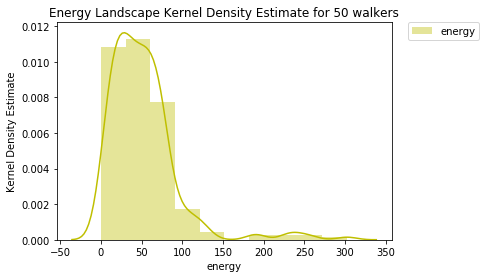

In [67]:
for i,j in enumerate(landscapes):
    df = pd.DataFrame(j, index=[0]).T.reset_index().rename(columns={"index":"energy", 0:"count"})
    if i == 0:
        count = 50
    elif i == 1:
        count = 300
    else:
        count = 1000
        
    fig, ax1 = plt.subplots(1, 1)
    plt.title("Energy Landscape Kernel Density Estimate for {} walkers".format(count))
    plt.xlabel("Energy")
    plt.ylabel("Kernel Density Estimate")
    sns.distplot(df['energy'], color='y', label='energy', bins=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


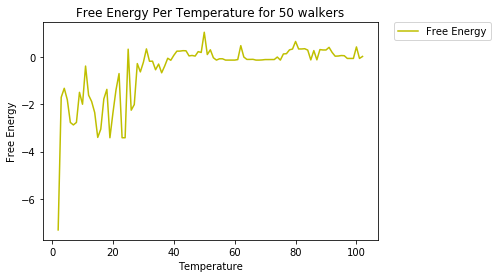

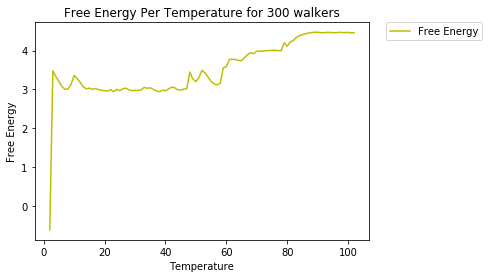

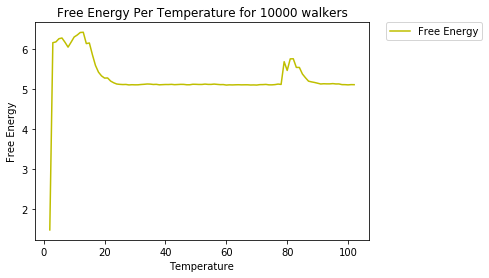

In [53]:
for i,j in enumerate(free_energies):
    df = pd.DataFrame(j, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"free_energy"})
    if i == 0:
        count = 50
    elif i == 1:
        count = 300
    else:
        count = 10000
    fig, ax1 = plt.subplots(1, 1)
    plt.title("Free Energy Per Temperature for {} walkers".format(count))
    sns.lineplot(df['temperature'],df['free_energy'], color='y', label='Free Energy')
    plt.xlabel("Temperature")
    plt.ylabel("Free Energy")
    #plt.gca().invert_xaxis()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

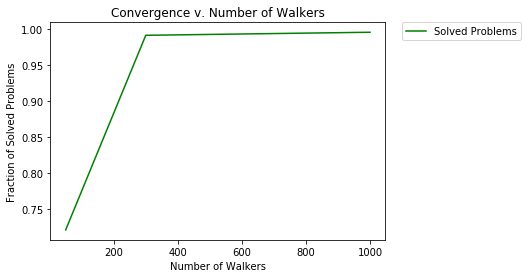

In [49]:
fig, ax1 = plt.subplots(1, 1)
plt.title("Convergence v. Number of Walkers".format(count))
sns.lineplot(x=exp_space, y=convs, color='g', label='Solved Problems')
plt.xlabel("Number of Walkers")
plt.ylabel("Fraction of Solved Problems")
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

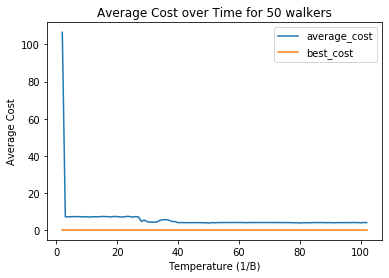

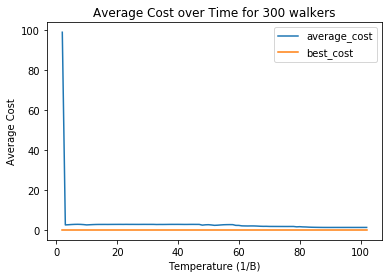

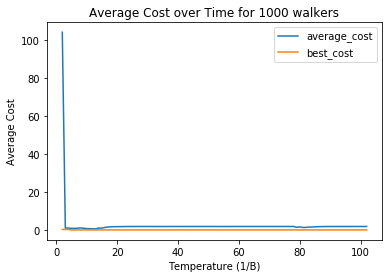

In [56]:
for i,j in enumerate(average):
    if i == 0:
        count = 50
    elif i == 1:
        count = 300
    else:
        count = 1000
    fig, ax1 = plt.subplots(1, 1)
    best_costs = best[i]
    sns.lineplot(temperature[1:], j, label='average_cost')
    sns.lineplot(temperature[1:], best_costs, label='best_cost')
    plt.title("Average Cost over Time for {} walkers".format(count))
    plt.xlabel("Temperature (1/B)")
    plt.ylabel("Average Cost")

In [ ]:
# explore = int(5 * 10e4)
explore=30
a = PAAnneal(maxsteps=101, explore=10, walkers=explore)
(energy_landscape, average_cost, cumulative, free_energy, best_cost_change, best_cost, population,\
    temperature, walker_z, resample_time, config_time) = a.anneal()

# walker_z_df = pd.DataFrame.from_records(walker_z).rename(columns={0:"temp", 1:"sweep", 2:"walker", 3:"partition_function"})
# walker_z_df.head()


## New Resampling method for 50 - 200 walkers (Choose by Taus)

In [ ]:
random_free_energies, random_landscapes, random_average, random_best, random_pops, random_convs = list(), list(), list(), list(), list(), list()

In [64]:
exp_space = [50,300,1000]

for i in exp_space:

    a = RandomAnneal(maxsteps=101, explore=10, walkers=i)
    (energy_landscape, average_cost, cumulative, free_energy, best_cost_so_far, all_best_costs, population,\
    temperature, walker_z, resample_time, config_time) = a.anneal()
    
    convergence = cumulative / np.sum(population)
    print("Convergence Rate: {}".format(convergence))
    random_landscapes.append(energy_landscape)
    random_free_energies.append(free_energy)
    random_average.append(average_cost)
    random_best.append(all_best_costs)
    random_pops.append(population)
    random_convs.append(convergence)

KeyboardInterrupt: 

In [ ]:
for i,j in enumerate(landscapes):
    df = pd.DataFrame(j, index=[0]).T.reset_index().rename(columns={"index":"energy", 0:"count"})
    if i == 0:
        count = 50
    elif i == 1:
        count = 300
        
    fig, ax1 = plt.subplots(1, 1)
    plt.title("Energy Landscape Kernel Density Estimate for {} walkers".format(count))
    plt.xlabel("Energy")
    plt.ylabel("Kernel Density Estimate")
    sns.distplot(df['energy'], color='y', label='energy', bins=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
for i,j in enumerate(free_energies):
    df = pd.DataFrame(j, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"free_energy"})
    if i == 0:
        count = 50
    elif i == 1:
        count = 300
    fig, ax1 = plt.subplots(1, 1)
    plt.title("Free Energy Per Temperature for {} walkers".format(count))
    sns.lineplot(df['temperature'],df['free_energy'], color='y', label='Free Energy')
    plt.xlabel("Temperature")
    plt.ylabel("Free Energy")
    #plt.gca().invert_xaxis()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

In [ ]:
fig, ax1 = plt.subplots(1, 1)
plt.title("Convergence v. Number of Walkers".format(count))
sns.lineplot(x=exp_space, y=convs, color='g', label='Solved Problems')
plt.xlabel("Number of Walkers")
plt.ylabel("Fraction of Solved Problems")
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

In [ ]:
for i,j in enumerate(average):
    if i == 0:
        count = 50
    elif i == 1:
        count = 300
    fig, ax1 = plt.subplots(1, 1)
    best_costs = best[i]
    sns.lineplot(temperature[1:], j, label='average_cost')
    sns.lineplot(temperature[1:], best_costs, label='best_cost')
    plt.title("Average Cost over Time for {} walkers".format(count))
    plt.xlabel("Temperature (1/B)")
    plt.ylabel("Average Cost")

# One Sample Run (50 Walkers)
## Followed by plotting the energy landscape & count / energy landscape & temperature

In [19]:
import cProfile

testing_profiles = [50, 100, 1000, 10000]

# explore = int(5 * 10e4)
for test in testing_profiles:
    explore = test
    a = PAAnneal(maxsteps=101, explore=10, walkers=explore)
    cProfile.run('a.anneal()')

0.007355212814216947
         8852375 function calls in 16.520 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    49960    0.598    0.000    0.598    0.000 <ipython-input-2-3c2ef990f0d6>:34(func)
     4952    0.020    0.000    0.020    0.000 <ipython-input-5-3e2b5abf5bf9>:122(acceptance_probability)
      101    0.001    0.000    0.005    0.000 <ipython-input-5-3e2b5abf5bf9>:138(check_correct)
      101    0.003    0.000    0.003    0.000 <ipython-input-5-3e2b5abf5bf9>:139(<listcomp>)
        1    0.000    0.000    0.000    0.000 <ipython-input-5-3e2b5abf5bf9>:141(max_key)
       50    0.000    0.000    0.000    0.000 <ipython-input-5-3e2b5abf5bf9>:147(<lambda>)
        1    0.572    0.572   16.513   16.513 <ipython-input-5-3e2b5abf5bf9>:172(anneal)
        1    0.000    0.000    0.000    0.000 <ipython-input-5-3e2b5abf5bf9>:199(<dictcomp>)
        1    0.000    0.000    0.000    0.000 <ipython-input-5-3e2b5abf5bf9>:202(<d

KeyboardInterrupt: 

In [ ]:
explore = [50] + [i for i in range(100, 500, 100)]
convergent = {"explore": list(), "best_cost": list(), "converge":list()}
for i in explore:
    a = PAAnneal(maxsteps=500, walkers=i)
    energy_landscape, average_cost, cumulative, free_energy, best_cost_change, best_cost, population, temperature, walker_z = a.anneal()
    convergent['explore'].append(i)
    convergent['best_cost'].append(best_cost_change)
    convergent['converge'].append(cumulative/np.sum(population))


converge_df = pd.DataFrame.from_dict(convergent)
converge_df.head()


In [ ]:
converge_df.plot(x = 'explore', y = 'converge', kind='line', label='convergence')
plt.title('Convergence v. Number of Walkers')
plt.xlabel('explore')
plt.ylabel('fraction of problems converged')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
converge_df.plot(x = 'explore', y = 'best_cost', kind='line', label='best cost')
plt.title('Best Cost v. Number of explorers')
plt.xlabel('best cost')
plt.ylabel('fraction of problems converged')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
a = PAAnneal(maxsteps=500, walkers=explore)
energy_landscape, average_cost, cumulative, free_energy, best_cost_change, best_cost, population, temperature, walker_z = a.anneal()

walker_z_df = pd.DataFrame.from_records(walker_z).rename(columns={0:"temp", 1:"sweep", 2:"walker", 3:"partition_function"})
walker_z_df.head()


In [ ]:
walker_explore = np.sort(np.random.randint(1, explore, size=10))[::-1]
temps = [i for i in range(50, 5000, 500)]
cumulative_sum = {"walker": list(), "temp": list(), "cumulative":list()}

for i in temps:
    for walker in walker_explore:
        sum_df = np.sum(np.cumsum(walker_z_df[(walker_z_df['temp']==i) & (walker_z_df['walker']==walker)])['partition_function'])
        cumulative_sum['walker'].append(walker)
        cumulative_sum['temp'].append(i)
        cumulative_sum['cumulative'].append(sum_df)

df = pd.DataFrame.from_dict(cumulative_sum)
plt.title("Evolution of Partition Function per Sweep")
plt.xlabel("Sweep")
plt.ylabel("Partition Function (Z)")
sns.lineplot(df['temp'], df['cumulative'], color='y', label='walker')
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
walker_z_df_walker = walker_z_df.groupby(['sweep']).mean().reset_index()
#walker_z_df_walker = walker_z_df_walker[(walker_z_df_walker['temp']==2500) & (walker_z_df_walker['walker']==2000)]
#    print(walker_z_df_walker['partition_function'])
plt.title("Evolution of Partition Function per Sweep")
plt.xlabel("Sweep")
plt.ylabel("Partition Function (Z)")
sns.lineplot(walker_z_df_walker['sweep'], walker_z_df_walker['partition_function'], color='y', label='Partition Function')
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
walker_z_df_walker = walker_z_df.groupby(['temp']).mean().reset_index()
#walker_z_df_walker = walker_z_df_walker[(walker_z_df_walker['temp']==i) & (walker_z_df_walker['walker']==2000)]
#    print(walker_z_df_walker['partition_function'])
plt.title("Evolution of Partition Function per Sweep")
plt.xlabel("Sweep")
plt.ylabel("Partition Function (Z)")
sns.lineplot(walker_z_df_walker['temp'], walker_z_df_walker['partition_function'], color='y', label='Partition Function')
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
# need to explore maybe - 5 sets of low temperature, 5 sets of medium temperature, 5 sets of high temperature
temp_explore = [np.sort(np.random.randint(4000, 5000, size=5))[::-1], np.sort(np.random.randint(3000, 4000, size=5))[::-1], \
                np.sort(np.random.randint(2000, 3000, size=5))[::-1], np.sort(np.random.randint(1000, 2000, size=5))[::-1], \
                np.sort(np.random.randint(0, 1000, size=5))[::-1]]

for temps in temp_explore:
    fig = plt.subplots()
    plt.title("Evolution of Partition Function per Sweep {}".format(round(temps[0],-3)))
    plt.xlabel("Sweep")
    plt.ylabel("Partition Function (Z)")
    for j in temps:
        walker_z_df_walker = walker_z_df[(walker_z_df['temp']==j) & (walker_z_df['walker']==25)]
        walker_z_df_walker.head()
        sns.lineplot(walker_z_df_walker['sweep'], walker_z_df_walker['partition_function'], label='Partition Function at B: {}'.format(j))
    # move the plot outside fo the graph
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('partition_{}.png'.format(round(temps[0],-3)))

In [ ]:
# deploy on cloud
#explore = [i for i in range(1, 1001, 50)]

# write to a dataframe and a raw csv
pop_anneal = {"run":list(), 'temperature':list(), "energy_landscape":list(), "divergence":list(), \
              "converged_perc":list(), "best_cost":list(), "avg_cost_temp": list(), "temp_pop":list(), \
             "total_pop":list()}
explore = 50
iters = 100

for i in range(100):
    a = Annealer(maxsteps=5000, walkers=explore)
    energy_landscape, average_cost, cumulative, kl_divergence, best_cost, population, temp, walker_z = a.anneal()
    temp = [0] + temp
    temp = temp[:-2]
    total_population = np.sum(population)
    new_divergence = np.abs([0 if math.isinf(v) == True else v for k,v in kl_divergence.items()])
    for j in temp:
        pop_anneal['run'].append(i)
        pop_anneal['temperature'].append(j)
        pop_anneal['energy_landscape'].append(energy_landscape)
        pop_anneal['divergence'].append(new_divergence[j])
        pop_anneal["converged_perc"].append(cumulative/total_population)
        pop_anneal["best_cost"].append(best_cost[2])
        # need to implement average cost every time step
        pop_anneal["avg_cost_temp"].append(average_cost[j])
        pop_anneal["temp_pop"].append(population[j])
        pop_anneal["total_pop"].append(total_population)
        
anneal_run = pd.DataFrame.from_dict(pop_anneal)
anneal_run.head()
#anneal_run.to_csv("PA_run_test.csv")

## Some sample plotting code

In [ ]:
df = pd.DataFrame(free_energy, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"free_energy"})
plt.title("Free Energy Per Temperature")
sns.lineplot(df['temperature'],df['free_energy'], color='y', label='Free Energy')
plt.xlabel("Temperature")
plt.ylabel("Free Energy")
plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

In [ ]:
free = free_energy.copy()
for k,v in free.items():
    free[k] = free[k]/(-1/k)

df = pd.DataFrame(free, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"free_energy"})
plt.title("Free Energy Per Temperature")
sns.lineplot(df['temperature'],df['free_energy'], color='y', label='Free Energy')
plt.xlabel("Temperature")
plt.ylabel("Free Energy")
plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

In [ ]:
df = pd.DataFrame(kl_divergence, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"divergence"})
plt.title("KL Divergence Per Temperature")
sns.lineplot(df['temperature'],df['divergence'], color='y', label='Kullbeck Leibler Divergence')
plt.xlabel("Temperature")
plt.ylabel("Divergence")
#plt.gca().invert_xaxis()
plt.legend()

# kulbeck leiber divergence 
# cross entropy

In [ ]:
df = pd.DataFrame(energy_landscape, index=[0]).T.reset_index().rename(columns={"index":"energy", 0:"count"})
plt.title("Energy Landscape Kernel Density Estimate")
plt.xlabel("Energy")
plt.ylabel("Kernel Density Estimate")
sns.distplot(df['energy'], color='y', label='energy', bins=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# kulbeck leiber divergence 
# cross entropy

In [ ]:
#population = [np.mean(i) for i in pop]
#temp = [np.mean(i) for i in temperature]
best_costs = [i for i in best_cost]
sns.lineplot(temperature, average_cost, label='average_cost')
sns.lineplot(temperature, best_costs, label='best_cost')
plt.title("Average Cost over Time")
plt.xlabel("Temperature (1/B)")
plt.ylabel("Average Cost")
plt.legend()
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.xlim(0.5, 0)

In [ ]:
#population = [np.mean(i) for i in pop]
#temp = [np.mean(i) for i in temperature]
sns.lineplot(temperature, population, label='number_of_walkers')
plt.title("Number of Walkers over Time")
plt.xlabel("Temperature (1/B)")
plt.ylabel("Number of Walkers")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().invert_xaxis()

#plt.xlim(0.5, 0)